In [1]:

import numpy as np
import matplotlib.pyplot as plt

from gp_ima.ima import C_ima_digamma, C_ima_sample
import GPy
from tueplots import bundles, figsizes

In [2]:
import sys

%load_ext autoreload
%autoreload 2

sys.path.insert(0, '.')

In [47]:
from analysis import plot_typography, estimate2uniform, generate_moebius_data, format_violin, RED, BLUE

In [5]:
USETEX = True

In [6]:
plt.rcParams.update(bundles.neurips2022(usetex=USETEX))
plt.rcParams.update({
    'text.latex.preamble': [r'\usepackage{amsfonts}', # mathbb
                            r'\usepackage{amsmath}'] # boldsymbol
})

 /usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/_collections_abc.py:941: MatplotlibDeprecationWarning:Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [7]:
plot_typography(usetex=USETEX, small=12, medium=16, big=20)

In [48]:
NUM_DATA = 500
LATENT_DIM = OBS_DIM = 2
SEED = 42

np.random.seed(SEED)
Z, X, c = generate_moebius_data(NUM_DATA, LATENT_DIM, OBS_DIM)

In [42]:
def train_bayesian_gplvm(dim, num_samples_c_ima, num_restarts, num_seeds, seed):
    cimas_sparse = []
    cimas_sparse_prior = []
    zs_sparse = []
    zs_uni_sparse = []
    np.random.seed(seed)
    for i in range(num_seeds):
        kernel = GPy.kern.RBF(dim, ARD=False) + GPy.kern.Bias(dim)
        m = GPy.models.BayesianGPLVM(np.asarray(X), dim, kernel=kernel, num_inducing=20)
        m.likelihood = GPy.likelihoods.Gaussian(variance=1e-4)
        cimas_sparse_prior.append(np.mean([C_ima_sample(m) for _ in range(num_samples_c_ima)]))
        m.optimize_restarts(num_restarts, optimizer='lbfgs')

        cimas_sparse.append(np.mean([C_ima_sample(m) for _ in range(num_samples_c_ima)]))
        zs_sparse.append(m.X.mean)
        zs_uni_sparse.append(estimate2uniform(zs_sparse[-1]))

    return cimas_sparse, cimas_sparse_prior, zs_sparse , zs_uni_sparse

def train_gplvm(dim, num_samples_c_ima, num_restarts, num_seeds, seed):
    cimas = []
    cimas_prior = []
    zs = []
    zs_uni = []
    np.random.seed(seed)
    for i in range(num_seeds):
        kernel = GPy.kern.RBF(dim, ARD=False) + GPy.kern.Bias(dim)
        m = GPy.models.GPLVM(np.asarray(X), dim, kernel=kernel)
        m.likelihood = GPy.likelihoods.Gaussian(variance=1e-6)
        cimas_prior.append(np.mean([C_ima_sample(m) for _ in range(num_samples_c_ima)]))
        m.optimize_restarts(num_restarts, optimizer='lbfgs')

        cimas.append(np.mean([C_ima_sample(m) for _ in range(num_samples_c_ima)]))
        zs.append(m.X.values)
        zs_uni.append(estimate2uniform(zs[-1]))

    return cimas, cimas_prior, zs , zs_uni



Optimization restart 1/5, f = -2596.4202124419394
Optimization restart 2/5, f = -2596.4172090978896
Optimization restart 3/5, f = -2596.4198410951863
Optimization restart 4/5, f = -2596.4193691671594
Optimization restart 5/5, f = -2342.3127646550947
Optimization restart 1/5, f = -2596.4192268388188
Optimization restart 2/5, f = -2596.4194532763227
Optimization restart 3/5, f = -2353.80913556185
Optimization restart 4/5, f = -2169.0996624777918
Optimization restart 5/5, f = -2281.748069107265
Optimization restart 1/5, f = -2596.419515285671
Optimization restart 2/5, f = -2316.909745619596
Optimization restart 3/5, f = -2297.624583302467
Optimization restart 4/5, f = -2596.417724017836
Optimization restart 5/5, f = -2596.418611314886
Optimization restart 1/5, f = -2596.418841509837
Optimization restart 2/5, f = -2395.764986532248
Optimization restart 3/5, f = -2596.419911639028
Optimization restart 4/5, f = -2596.419147393385
Optimization restart 5/5, f = -2596.417172499977
Optimization 

In [ ]:
NUM_SEEDS = 5
NUM_SAMPLES_C_IMA = 100
NUM_RESTARTS = 5
DIM = 2
cimas_sparse, cimas_sparse_prior, zs_sparse , zs_uni_sparse = train_bayesian_gplvm(DIM, NUM_SAMPLES_C_IMA, NUM_RESTARTS, NUM_SEEDS, SEED)


NUM_RESTARTS = 2
cimas, cimas_prior, zs , zs_uni = train_gplvm(DIM, NUM_SAMPLES_C_IMA, NUM_RESTARTS, NUM_SEEDS, SEED)

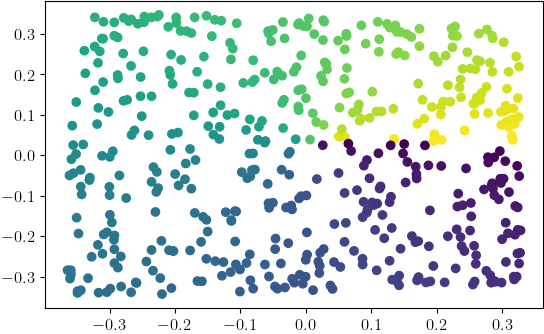

In [20]:
idx=0
plt.scatter(zs_uni_sparse[idx][:, 0], zs_uni_sparse[idx][:, 1], c=c)

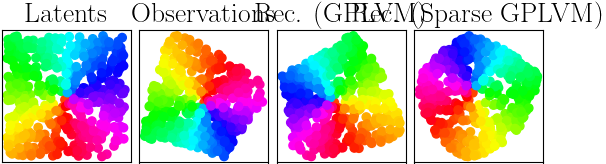

In [43]:
LABELPAD = 1
TICK_PADDING = 2
IDX = 0
IDX_SPARSE = 1
fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=2, rel_width=1)['figure.figsize'])




ax = fig.add_subplot(141)
ax.scatter(Z[:, 0], Z[:, 1], c=c, cmap="hsv", label="Latents")

ax2 = fig.add_subplot(142)
ax2.scatter(X[:, 0], X[:, 1], c=c, cmap="hsv", label="Observations")

ax3 = fig.add_subplot(143)
ax3.scatter(zs_uni[IDX][:, 0], zs_uni[IDX][:, 1], c=c, cmap="hsv", label="Rec. (GPLVM)")


ax4 = fig.add_subplot(144)
ax4.scatter(zs_uni_sparse[IDX_SPARSE][:, 0], zs_uni_sparse[IDX_SPARSE][:, 1], c=c, cmap="hsv", label="Rec. (Sparse GPLVM)")


# Remove ticks and labels and set which side to label
ticksoff = dict(labelleft=False, labelright=False, left=False, right=False, labelbottom=False, bottom=False)
ax.tick_params(axis="both", **ticksoff)
ax2.tick_params(axis="both", **ticksoff)
ax3.tick_params(axis="both", **ticksoff)
ax4.tick_params(axis="both", **ticksoff)

ax.set_title("Latents")
ax2.set_title("Observations")
ax3.set_title("Rec. (GPLVM)")
ax4.set_title("Rec. (Sparse GPLVM)")



plt.savefig("gplvm_ima.svg")

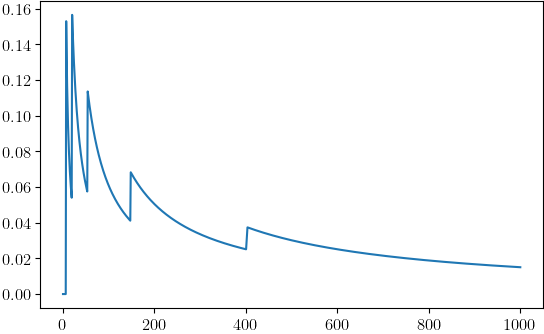

In [16]:
Ds = np.logspace(0, 3, 1000).astype(int)
plt.plot(Ds, [C_ima_digamma(max(1, int(np.log(D))), D) for D in Ds])

In [46]:
cimas_sparse, cimas, cimas_sparse_prior, cimas_prior

([0.16782003260001008,
  0.170218781266272,
  0.1662057568311114,
  0.1636610349933116,
  0.17055443499919298],
 [0.0022708264143404175],
 [0.22792388438164862,
  0.23834538021753654,
  0.2743697755324752,
  0.17037810985987015,
  0.2669504399909944],
 [0.15824154315743974])

In [26]:
# fig = plt.figure(figsize=figsizes.neurips2022(nrows=1, ncols=1, rel_width=1)['figure.figsize'])
#
# ax = fig.add_subplot(111)

vp2= plt.violinplot([np.log10(g) for g in cimas_sparse], showmedians=True)
format_violin(vp2, RED)


[autoreload of numpy.matrixlib failed: Traceback (most recent call last):
  File "/Users/patrik.reizinger/gp-ima/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/patrik.reizinger/gp-ima/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/local/Cellar/python@3.9/3.9.16/Frameworks/Python.framework/Versions/3.9/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/patrik.reizinger/gp-ima/lib/python3.9/site-packages/numpy/matrixlib/__init__.py", line 6, in <module>
    __all__ = defmatrix.__all__
NameError: name 'defmatrix' is not defined
]
[autoreload of numpy.

TypeError: float() argument must be a string or a number, not '_NoValueType'

In [27]:
np.__version__

'1.23.5'